# Structural Analysis of a Lathe Cutter

### Objective  
The objective of this example is to highlight some of the often-used PyMAPDL categories via a lathe cutter finite element model.  Lathe cutters have multiple avenues of wear and failure, and the analyses supporting their design would most often be transient thermal-structural.  However, for simplicity, we will simulate this with a non-uniform load.

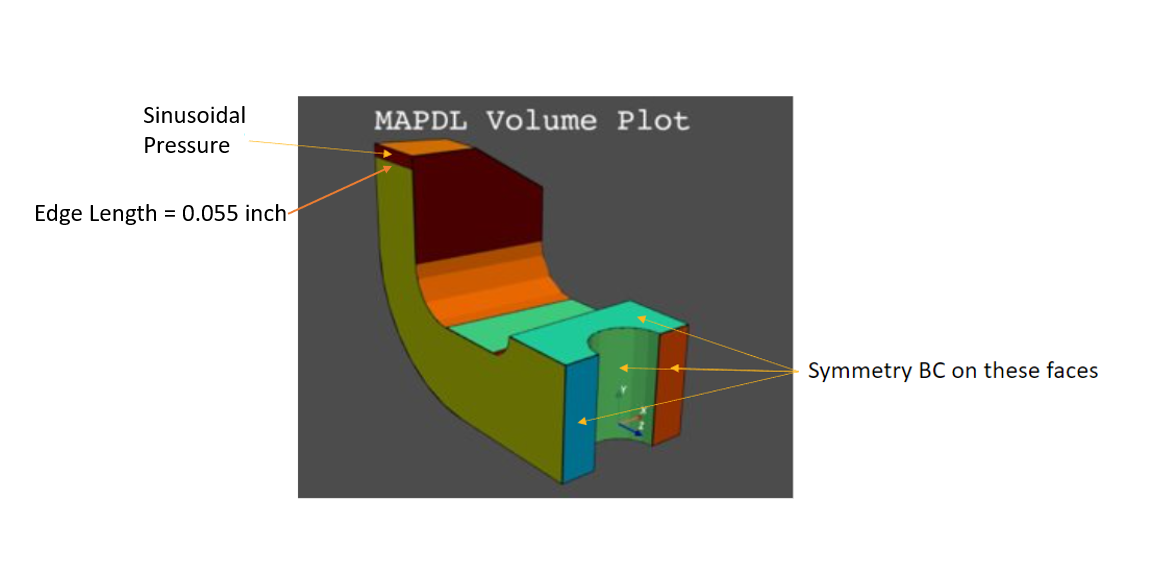

###
* [OS](https://docs.python.org/3/library/os.html) is used for Python method to get the current working directory
* [Numpy](https://numpy.org/) is used for Numpy arrays and functions 

### Procedure  

1 Define necessary variables and launch MAPDL  
2 Import geometry and inspect for MAPDL parameters. Define linear elastic material model with Python variables.  Mesh and apply symmetry boundary conditions  
3 Create a local coordinate system for applied load and verify with plot  
4 Define the pressure load as a sine function of the length of the application area using numpy arrays; import the pressure array into MAPDL as a table array; verify the applied load, and solve  
5 Show result plotting; plotting with selection; and working with the plot legend  
  List a result two ways - PyMAPDL and Pythonic version of APDL showing extended method; write list to a file.  
6 Use of mesh.grid for additional post processing

## Step 1 
Define variables and launch MAPDL

In [1]:
import os
import numpy as np
from ansys.mapdl.core import launch_mapdl

# cwd = current working directory

path = os.getcwd()
PI = np.pi
EXX = 1.0E7
NU = 0.27

# Often used MAPDL command line options are given Pythonic names in the launch_mapdl function; for example -dir has become run_location
# Options without a Pythonic version can be accessed by the additional_switches parameter:  
# Here we use -smp only to keep the number of solver files to a minimum, as we will be creating files in the working directory later 
# and opening them via Jupyter Lab and wish the list of files to be small.

mapdl = launch_mapdl(run_location=path, additional_switches='-smp')

ModuleNotFoundError: No module named 'ansys.mapdl'

## Step 2  
Import geometry and inspect for MAPDL parameters  
Define material, mesh, and create boundary conditions

In [ ]:
# reset the MAPDL database
mapdl.clear()

# import the geometry file and list any MAPDL parameters

mapdl.input('LatheCutter.anf')
mapdl.finish()
mapdl.parameters

In [ ]:
# Will use pressure area length in load definition so save as Python variable  

pressure_length = mapdl.parameters['PRESS_LENGTH']
pressure_length
mapdl.parameters["Presadfdfdsa"] = '123456789'

mapdl.parameters

In [ ]:
mapdl.units('Bin')
mapdl.title('Lathe Cutter')
mapdl.prep7()

mapdl.mp('EX', 1, EXX)
mapdl.mp('NUXY', 1, NU)

# The MAPDL element type Solid285 is used for demonstration purposes.  Consider using an appropriate
# element type or mesh density for your actual application.

mapdl.et(1,285)
mapdl.smrtsize(4)
mapdl.aesize(14,0.0025)
mapdl.vmesh(1)

mapdl.da(11,'symm')
mapdl.da(16,'symm')
mapdl.da(9,'symm')
mapdl.da(10,'symm')

## Step 3

Create Local Coordinate System (CS) for Applied Pressure as a Function of Local X   

In [ ]:
# Local CS ID is 11

mapdl.cskp(11,0,2,1,13)
mapdl.csys(1)
mapdl.view(1,-1,1,1)
mapdl.psymb('CS',1)
#mapdl.vplot(color_areas=True, show_lines=True, cpos=[-1,1,1])

# VTK plots do not show MAPDL plot symbols.  Can comment out the vplot line above, then uncomment the lplot line below
# and then re-run just this cell to get the line plot with the coordinate system symbol to verify.

mapdl.lplot(vtk=False)

## Step 4  

Create pressure, load it into MAPDL as a Table array, verify the load, and solve 

In [ ]:
# pressure_length = 0.055 inch

pts = 10
pts_1 = pts - 1

length_x = np.arange(0,pts,1)
length_x = length_x*pressure_length/pts_1

press = 10000*(np.sin(PI*length_x/pressure_length))

# length_x and press are vectors; can use Numpy stack function to combine them into the correct
# form needed to define the MAPDL table array

press = np.stack((length_x,press),axis=-1)
#print(press)

mapdl.load_table('MY_PRESS', press, 'X',csysid=11)

mapdl.asel('S','Area','',14)
mapdl.nsla('S',1)
mapdl.sf('All', 'Press', '%MY_PRESS%')
mapdl.allsel()

In [ ]:
#mapdl.open_gui()

In [ ]:
mapdl.finish()
mapdl.slashsolu()
mapdl.nlgeom('On')
mapdl.psf('PRES','NORM',3,0,1)
mapdl.view(1,-1,1,1)
mapdl.eplot(vtk=False)

In [ ]:
mapdl.solve()
mapdl.finish()
mapdl.solution.converged

## Step 5

### Post Processing - Plotting

In [ ]:
mapdl.post1()
mapdl.set('last')
mapdl.allsel()

In [ ]:
mapdl.post_processing.plot_nodal_principal_stress('1', smooth_shading=False)

### Plotting - Part of Model

In [ ]:
mapdl.csys(1)
mapdl.nsel('S', 'LOC', 'Z', -.5, -.141)
mapdl.esln()
mapdl.nsle()
mapdl.post_processing.plot_nodal_principal_stress('1', edge_color='white', show_edges=True)

### Plotting - Legend Options

In [ ]:
mapdl.allsel()
sbar_kwargs = {"color": "black", "title": "1st Principal Stress (psi)", "vertical": False, "n_labels": 6}
mapdl.post_processing.plot_nodal_principal_stress('1', cpos='xy',background='white',
                                                  edge_color='black', show_edges=True, scalar_bar_args=sbar_kwargs,
                                                  n_colors=9)

In [ ]:
'''
Try out some scalar bar options from the PyVista documentation for fun  
Black text on Beige background seems pretty sharp
Scalar Bar Keywords defined with the Python dictionary function, an alternate method to using {key:value}'s 
The Scalar Bar can be click-dragged to a new position.  Left-click it and hold down the left mouse button while moving mouse to reposition. 
''' 


'''sbar_kwargs = dict(
    title_font_size=20,
    label_font_size=16,
    shadow=True,
    n_labels=9,
    italic=True,
    bold=True,
    fmt="%.1f",
    font_family="arial",
    title='1st Principal Stress (psi)',
    color='black',
)
mapdl.post_processing.plot_nodal_principal_stress('1', cpos='xy',background='beige',
                                                  edge_color='black', show_edges=True, scalar_bar_args=sbar_kwargs,
                                                  n_colors=256,cmap='jet') 

# cmap names *_r usually reverses values.  Try cmap='jet_r' '''


### Post Processing - Result Listing  

In [ ]:
mapdl.post_processing.nodal_principal_stress('1')

In [ ]:
mapdl.nsel('S', 'S', 1, 6700, 7720)
mapdl.esln()
mapdl.nsle()

mapdl.mesh.nnum

In [ ]:
mapdl.post_processing.nodal_principal_stress('1')

In [ ]:
print(mapdl.prnsol('S', 'PRIN',))

In [ ]:
mapdl_s_1_list = mapdl.prnsol('S', 'PRIN',).to_list()
mapdl_s_1_list

In [ ]:
mapdl_s_1_df = mapdl.prnsol('S', 'PRIN',).to_dataframe()
mapdl_s_1_df

In [ ]:
# Data Frame is a Pandas data type.  Pandas module is imported now, so can use its functions.  
# For example writing these principal stresses to a file.  Compare to MAPDL method.

#mapdl_s_1_df.to_csv(path + '\prin-stresses.csv')
#mapdl_s_1_df.to_json(path + '\prin-stresses.json')
mapdl_s_1_df.to_html(path + '\prin-stresses.html')

## Step 6  
Additional post processing

In [ ]:
mapdl.allsel()
principal_1 = mapdl.post_processing.nodal_principal_stress('1')

# Load this result into the VTK grid
grid = mapdl.mesh.grid
grid["p1"] = principal_1

sbar_kwargs = {"color": "black", "title": "1st Principal Stress (psi)", "vertical": False, "n_labels": 6}

# generate a single horizontal slice slice along the XY plane
single_slice = grid.slice(normal=[0, 0, 1], origin=[0, 0, 0])
single_slice.plot(scalars='p1', background='white', lighting=False, show_edges=False, cmap='jet', n_colors=9, scalar_bar_args=sbar_kwargs)

In [ ]:
# generate plot with three slice planes
slices = grid.slice_orthogonal()
slices.plot(scalars="p1", background='white', lighting=False, show_edges=False, cmap='jet', n_colors=9, scalar_bar_args=sbar_kwargs)

In [ ]:
# Multiple slices in same plane
#slices = grid.slice_along_axis(12, "x")
#slices.plot(scalars="p1", background='white', lighting=False, show_edges=False, cmap='jet', n_colors=9, scalar_bar_args=sbar_kwargs)

In [ ]:
mapdl.exit()